# Getting Started

This tutorial is based on this `keras` tutorial: [keras Transfer Learning Guide](https://keras.io/guides/transfer_learning/).

We'll be creating a machine learning model using `keras` to classify images of cats and dogs.


First, import the necessary packages. You should also change your runtime to the GPU to speed it up.

In [ ]:
import os
os.environ["KERAS_BACKEND"] = "jax"
from keras import utils, datasets, models, layers
import tensorflow_datasets as tfds
import keras
from matplotlib import pyplot as plt
import numpy as np

Next, import the data.

In [ ]:
train_ds, validation_ds, test_ds = tfds.load(
    "cats_vs_dogs",
    # 40% for training, 10% for validation, and 10% for test (the rest unused)
    split=["train[:40%]", "train[40%:50%]", "train[50%:60%]"],
    as_supervised=True,  # Include labels
)

print(f"Number of training samples: {train_ds.cardinality()}")
print(f"Number of validation samples: {validation_ds.cardinality()}")
print(f"Number of test samples: {test_ds.cardinality()}")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/incomplete.6ZSVZN_4.0.1/cats_vs_dogs-train.tfrecord*...:   0%…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.
Number of training samples: 9305
Number of validation samples: 2326
Number of test samples: 2326


Next, we'll resize the data so that all pictures are the same size. We'll also split into train, validation, and test datasets.

In [ ]:
resize_fn = keras.layers.Resizing(150, 150)

train_ds = train_ds.map(lambda x, y: (resize_fn(x), y))
validation_ds = validation_ds.map(lambda x, y: (resize_fn(x), y))
test_ds = test_ds.map(lambda x, y: (resize_fn(x), y))

This next cell establishes an appropriate batch size so that the model loads data in a more efficient way.

In [ ]:
from tensorflow import data as tf_data
batch_size = 64

train_ds = train_ds.batch(batch_size).prefetch(tf_data.AUTOTUNE).cache()
validation_ds = validation_ds.batch(batch_size).prefetch(tf_data.AUTOTUNE).cache()
test_ds = test_ds.batch(batch_size).prefetch(tf_data.AUTOTUNE).cache()

Let's take a look at some of the data. The function `show_sample()` will display three pictures of cats and three pictures of dogs from our dataset.

In [ ]:
def show_sample():
  for images, labels in train_ds.take(1):
    plt.figure(figsize=(8,8))
    cats = [images[i] for i in range(64) if int(labels[i])==0]
    dogs = [images[i] for i in range(64) if int(labels[i])==1]
    for i in range(6):
      if i<3:
        ax = plt.subplot(2, 3, i + 1)
        plt.imshow(np.array(cats[i]).astype("int32"))
        plt.title('cat')
        plt.axis("off")
      else:
        ax = plt.subplot(2, 3, 1+i)
        plt.imshow(np.array(dogs[i]).astype("int32"))
        plt.title('dog')
        plt.axis("off")
    plt.tight_layout()

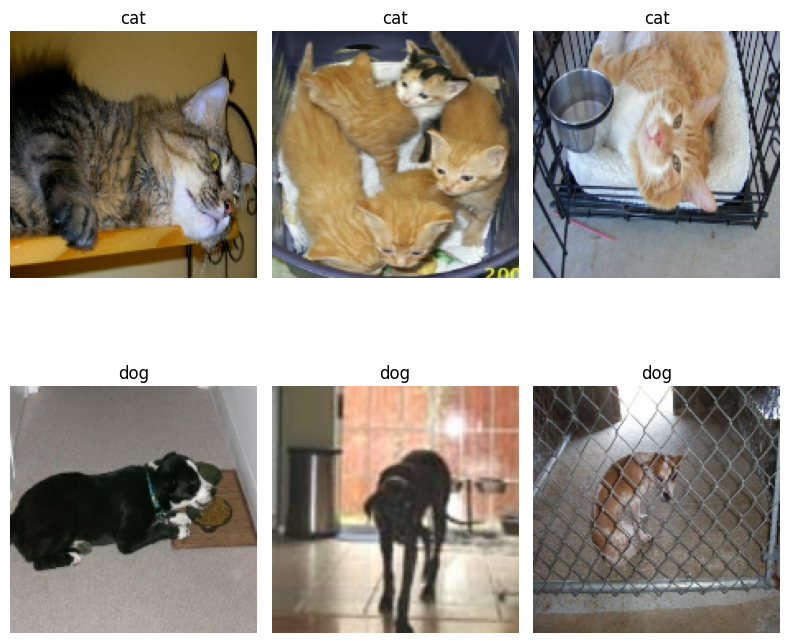

In [ ]:
show_sample()

# Modeling

## Baseline
The baseline model is the simplest one: the one that always guesses the mode, or most common result. What would this be for our dataset and how accurate would it be? We'll compare our later models to the baseline -- they should all perform better than the baseline. The next cell creates a numpy iterator over the dataset so that we can access data points.

In [ ]:
labels_iterator= train_ds.unbatch().map(lambda image, label: label).as_numpy_iterator()

In [ ]:
l = list(labels_iterator)
print(l.count(0), l.count(1))

4637 4668


It looks like our dataset contains 4637 images of cats and 4668 images of dogs, so the baseline model would guess 'dog' every time and it would be correct only slightly more than half of the time.

## Model 1
This is our first model using `keras`. We'll use the `models.Sequential()` method to build it using the provided `layers` from `keras`. This model is a basic first guess -- I chose the layers somewhat arbitrarily.

In [ ]:
model1 = models.Sequential([
    layers.Input((150, 150, 3)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.Dropout(0.2),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(2) # number of classes
])

In [ ]:
model1.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model1.summary()

history = model1.fit(train_ds,
                    epochs=20,
                    validation_data=validation_ds)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 72, 72, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 73984)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       4,735,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,778,082 (18.23 MB)

 Trainable params: 4,778,082 (18.23 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 11s 70ms/step - accuracy: 0.9378 - loss: 0.1895 - val_accuracy: 0.6776 - val_loss: 1.5971
Epoch 2/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 11s 71ms/step - accuracy: 0.9676 - loss: 0.0984 - val_accuracy: 0.6574 - val_loss: 1.8888
Epoch 3/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 15s 104ms/step - accuracy: 0.9585 - loss: 0.1300 - val_accuracy: 0.6681 - val_loss: 1.1964
Epoch 4/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 21s 143ms/step - accuracy: 0.9663 - loss: 0.0992 - val_accuracy: 0.6599 - val_loss: 1.7620
Epoch 5/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 13s 90ms/step - accuracy: 0.9665 - loss: 0.0999 - val_accuracy: 0.6414 - val_loss: 1.7613
Epoch 6/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 12s 82ms/step - accuracy: 0.9722 - loss: 0.0894 - val_accuracy: 0.6488 - val_loss: 1.7687
Epoch 7/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 12s 83ms/step - accuracy: 0.9812 - loss: 0.0587 - val_accuracy: 0.6462 - val_loss: 2.5134
Epoch 8/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 15s 103ms/step - accuracy: 0.9762 - loss: 0.0713

Now that we've compiled Model 1, we can take a look at the summary and accuracy. The summary tells us what each layer is doing -- take a look at each layer's inputs and outputs.



Let's write a quick function to visualize how the accuracy changes throughout the training process, which is 20 epochs.

In [ ]:
def history_visualization(history):
  plt.plot(history.history["accuracy"], label = "training")
  plt.plot(history.history["val_accuracy"], label = "validation")
  plt.gca().set(xlabel = "epoch", ylabel = "accuracy")
  plt.legend()

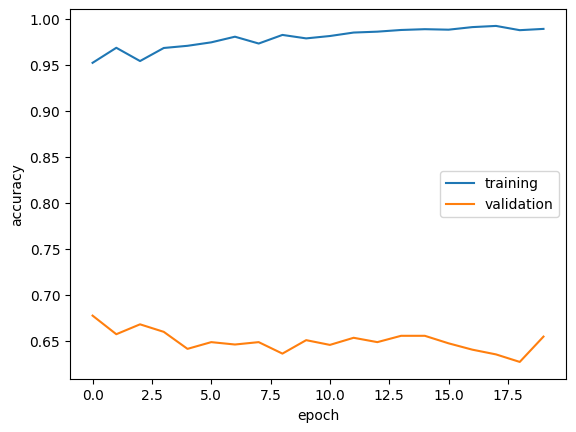

In [ ]:
history_visualization(history)

**The accuracy of Model 1 stabilized around 60%-65% during training.** This is better than the baseline, but the model is not as accurate as we would like on the validation data, and it looks like there's been some issues with overfitting. We'll work on that in the next models.

## Model 2
In this model, we'll add in some image aumentation to reduce overfitting. This entails adding in the `RandomFlip` and `RandomRotation` layers provided by `keras`. The following function will be used to visualize what these layers do to a sample image.

In [ ]:
def augmentation_visualization(image, f):
  plt.figure(figsize=(8,8), tight_layout=True)
  for i in range(6):
    ax = plt.subplot(2, 3, i + 1)
    augmented_image = f(np.expand_dims(image, 0))
    plt.imshow(np.array(augmented_image[0]).astype("int32"))
    plt.axis("off")

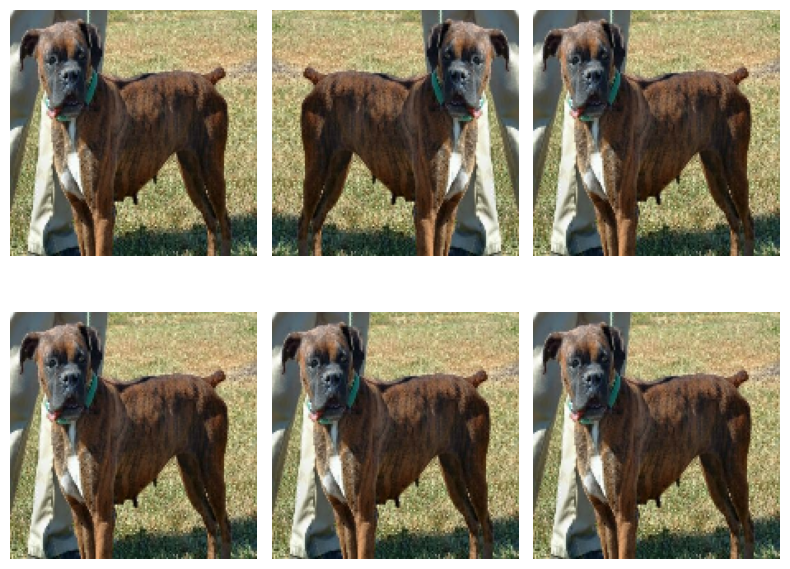

In [ ]:
for images, labels in train_ds.take(1):
    image = images[0]
    augmentation_visualization(image, layers.RandomFlip("horizontal"))
    break

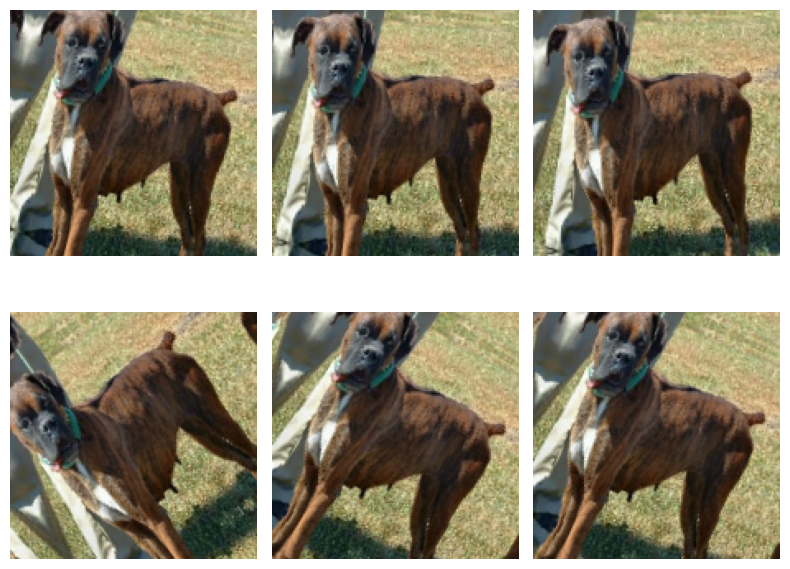

In [ ]:
augmentation_visualization(image, layers.RandomRotation(0.1))

Adding the data augmentation layers to the beginning of Model 1 gives us Model 2:

In [ ]:
model2 = models.Sequential([
    layers.Input((150, 150, 3)),
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Dropout(0.2),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(2) # number of classes
])

In [ ]:
model2.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model2.summary()

history = model2.fit(train_ds,
                    epochs=20,
                    validation_data=validation_ds)

Epoch 1/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 50s 269ms/step - accuracy: 0.5153 - loss: 9.5560 - val_accuracy: 0.5168 - val_loss: 0.6917
Epoch 2/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 30s 208ms/step - accuracy: 0.5247 - loss: 0.7039 - val_accuracy: 0.5241 - val_loss: 0.6878
Epoch 3/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 44s 300ms/step - accuracy: 0.5330 - loss: 0.6852 - val_accuracy: 0.5292 - val_loss: 0.6854
Epoch 4/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 42s 291ms/step - accuracy: 0.5521 - loss: 0.6828 - val_accuracy: 0.5344 - val_loss: 0.6839
Epoch 5/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 42s 291ms/step - accuracy: 0.5430 - loss: 0.6794 - val_accuracy: 0.5490 - val_loss: 0.6808
Epoch 6/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 32s 218ms/step - accuracy: 0.5581 - loss: 0.6767 - val_accuracy: 0.5529 - val_loss: 0.6766
Epoch 7/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 42s 291ms/step - accuracy: 0.5598 - loss: 0.6741 - val_accuracy: 0.5464 - val_loss: 0.6810
Epoch 8/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 42s 291ms/step - accuracy: 0.5617 - loss: 0

In [ ]:
history_visualization(history)

**Model 2 stabilized around 60% as well.** This is similar to Model 1, although it seems to have improved on the overfitting issue.

## Model 3

Let's make things a bit easier for the model by preprocessing the data. We will create a `preprocessor` layer which will normalize the data so that the model will be able to focus on legitimate signal in the data rather than adjusting the weights to the data scale.

In [ ]:
i = keras.Input(shape=(150, 150, 3))
# The pixel values have the range of (0, 255), but many models will work better if rescaled to (-1, 1.)
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(i)
preprocessor = keras.Model(inputs = i, outputs = x)

`model3` is identical to `model2` but with the `preprocessor` layer added.

In [ ]:
model3 = models.Sequential([
    preprocessor,
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Dropout(0.2),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(2) # number of classes
])

In [ ]:
model3.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model3.summary()

history = model3.fit(train_ds,
                    epochs=20,
                    validation_data=validation_ds)

Epoch 1/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 31s 212ms/step - accuracy: 0.5497 - loss: 0.7581 - val_accuracy: 0.6711 - val_loss: 0.6330
Epoch 2/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 31s 209ms/step - accuracy: 0.6505 - loss: 0.6215 - val_accuracy: 0.7180 - val_loss: 0.5581
Epoch 3/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 43s 293ms/step - accuracy: 0.7013 - loss: 0.5728 - val_accuracy: 0.7395 - val_loss: 0.5181
Epoch 4/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 43s 292ms/step - accuracy: 0.7297 - loss: 0.5358 - val_accuracy: 0.7627 - val_loss: 0.4862
Epoch 5/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 31s 211ms/step - accuracy: 0.7472 - loss: 0.5158 - val_accuracy: 0.7670 - val_loss: 0.4759
Epoch 6/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 42s 291ms/step - accuracy: 0.7655 - loss: 0.4880 - val_accuracy: 0.7764 - val_loss: 0.4646
Epoch 7/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 30s 209ms/step - accuracy: 0.7778 - loss: 0.4704 - val_accuracy: 0.7829 - val_loss: 0.4398
Epoch 8/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 31s 215ms/step - accuracy: 0.7857 - loss: 0

In [ ]:
history_visualization(history)

**Model 3 stabilized around 80%-85% accuracy.** This is much better than Model 1 and Model 2, and it seems like there is not much overfitting, since the training and validation scores are very close.

## Model 4
For this model, we'll build on someone else's model that has already been made. The next block will import the model and create a layer that we can put into our model.

In [ ]:
IMG_SHAPE = (150, 150, 3)
base_model = keras.applications.MobileNetV3Large(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               include_preprocessing=True,
                                               weights='imagenet')
base_model.trainable = False

i = keras.Input(shape=IMG_SHAPE)
x = base_model(i, training = False)
base_model_layer = keras.Model(inputs = i, outputs = x)

/usr/local/lib/python3.11/dist-packages/keras/src/applications/mobilenet_v3.py:517: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


12683000/12683000 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


We'll keep the data augmentation layers, but the preprocessing is taken care of by the `include_preprocessing` argument in `MobileNetV3Large`. Then I added one more `GlobalMaxPooling2D` layer, as well as the necessary final `Dense` layer of 2.

In [ ]:
model4 = models.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    base_model_layer,
    layers.GlobalMaxPooling2D(),
    layers.Dense(2)
])

In [ ]:
model4.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model4.summary()

history = model4.fit(train_ds,
                    epochs=20,
                    validation_data=validation_ds)

Epoch 1/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 83s 482ms/step - accuracy: 0.7739 - loss: 2.1566 - val_accuracy: 0.9497 - val_loss: 0.3776
Epoch 2/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 50s 340ms/step - accuracy: 0.9389 - loss: 0.4228 - val_accuracy: 0.9587 - val_loss: 0.2610
Epoch 3/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 49s 335ms/step - accuracy: 0.9465 - loss: 0.3392 - val_accuracy: 0.9656 - val_loss: 0.2187
Epoch 4/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 50s 341ms/step - accuracy: 0.9556 - loss: 0.2551 - val_accuracy: 0.9678 - val_loss: 0.1970
Epoch 5/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 49s 335ms/step - accuracy: 0.9589 - loss: 0.2180 - val_accuracy: 0.9695 - val_loss: 0.1803
Epoch 6/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 49s 335ms/step - accuracy: 0.9566 - loss: 0.2477 - val_accuracy: 0.9600 - val_loss: 0.2462
Epoch 7/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 52s 354ms/step - accuracy: 0.9603 - loss: 0.2332 - val_accuracy: 0.9626 - val_loss: 0.2493
Epoch 8/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 54s 371ms/step - accuracy: 0.9614 - loss: 0

In [ ]:
history_visualization(history)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ random_flip_4 (RandomFlip)           │ (64, 150, 150, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation_4 (RandomRotation)   │ (64, 150, 150, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_4 (Functional)            │ (64, 5, 5, 960)             │       2,996,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling2d_1               │ (64, 960)                   │               0 │
│ (GlobalMaxPooling2D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (64, 2)                     │           1,922 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,002,120 (11.45 MB)

 Trainable params: 1,922 (7.51 KB)

 Non-trainable params: 2,996,352 (11.43 MB)

 Optimizer params: 3,846 (15.02 KB)

**Model 4 stabilized around 96%-97% accuracy.** This is much better than our previous models. The validation score is around the same as the training score if not better, so the overfitting has been resolved.

## Testing on Unseen Data

In [ ]:
model4.evaluate(test_ds)

37/37 ━━━━━━━━━━━━━━━━━━━━ 21s 544ms/step - accuracy: 0.9624 - loss: 0.1594


[0.17607998847961426, 0.9643164277076721]

Model 4 was the best model, with a 96% accuracy score on the test dataset.